In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/EECS_442 Final Proj/WLASL/


/content/drive/.shortcut-targets-by-id/1Sc7VSl-7PU4L0hxklxePzLVSFNQ7pnLE/EECS_442 Final Proj/WLASL


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import math
import cv2
import json
import glob
import torchvision.transforms as transforms
import torch.nn
import torch.nn.functional as F
from sklearn import metrics
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
from torchvision import models as torch_models



In [ ]:
len(os.listdir('./optical_features/'))

991

Custom train_val split

In [ ]:
class VideoFeatureDataset(Dataset):
  def __init__(self, feature_dir, video_ids, label_dict, num_class):
    super().__init__()
    self.files = video_ids
    self.label_dict = label_dict
    self.num_class = num_class
    self.feature_dir = feature_dir

  def __getitem__(self, idx):
    curr_vid_id = self.files[idx]
    curr_vid_file = os.path.join(self.feature_dir, curr_vid_id+'.npy')
    f = np.load(curr_vid_file, allow_pickle=True)
    #lab = int(self.label_dict[curr_vid_id])
    lab = int(self.label_dict[curr_vid_id]['action'][0])
    label = np.zeros((self.num_class,)) # compute label e.g., [0,0,0,0,0...1,0,0,0...]
    label[lab] = 1
    return torch.from_numpy(f).float(), torch.from_numpy(label)

  def __len__(self):
    return len(self.files)

  def get_info(self):
    info = {}
    for f in self.files:
      id = f.split('/')[-1].split('.')[0]
      info[self.label_dict[id]] = info.get(self.label_dict[id], 0) + 1
    return info

    



In [ ]:
from PIL import Image
class OpticalDataset(Dataset):
  def __init__(self, img_dir, video_ids, label_dict, num_class):
    super().__init__()
    self.files = video_ids
    self.label_dict = label_dict
    self.num_class = num_class
    self.img_dir = img_dir

  def __getitem__(self, idx):
    folder = os.path.join(self.img_dir, self.files[idx]+'*.npy')
    imgs = list(sorted(glob.glob(folder)))
    images = []
    for img in imgs:
      im = np.array(Image.open(img))
      images.append(im)
    images = np.asarray(images, dtype=np.float32)
    images = images[:, 137:492, 16:480, :]
    images = torch.from_numpy(images)
    lab = int(self.label_dict[folder]['action'][0])
    label = np.zeros((self.num_class,)) # compute label e.g., [0,0,0,0,0...1,0,0,0...]
    label[lab] = 1
    return images, torch.from_numpy(label)

  def __len__(self):
    return len(self.files)



In [ ]:
device='cuda:0'

In [ ]:
import gc
gc.collect()

88

In [ ]:
class RNN_Att(torch.nn.Module):
    def __init__(self, num_class=100, feature_dim=512, hidden_dim=128, num_layers=2):
        super(RNN_Att, self).__init__()
        #self.fc1 = torch.nn.Linear(feature_dim, 1024)
        #self.fc2 = torch.nn.Linear(1024, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.pred = torch.nn.Linear(hidden_dim, num_class)
        self.softmax = torch.nn.Softmax(dim=1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(feature_dim, hidden_dim, bidirectional=True, batch_first=True)
        # self.lstm.append(lstm1)
        # lstm2 = torch.nn.LSTM(2 * hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        # self.lstm.append(lstm2)
        #lstm3 = torch.nn.LSTM(hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        #self.lstm.append(lstm3)
        self.att = torch.nn.Linear(hidden_dim, 1)
        self.bias = torch.nn.Parameter(torch.ones([100]))
        
        
    def forward(self, x):
        # b x 64 x 2048
        b, n, f = x.shape
        # x = self.fc1(x) # b x 64 x 512
        # x = self.fc2(x)
        output = x # b x 64 x 256
        h = torch.zeros((2, b, self.hidden_dim)).cuda()
        c = torch.zeros((2, b, self.hidden_dim)).cuda()
        h_history = []
        output, (h, c) = self.lstm(output, (h, c))
        print(output.shape) # batch x 50 x 64
        alphas = self.att(output) # batch x 50 x 1
        att = self.softmax(alphas) # batch x 50 x 1
        combined = output * att # batch x 50 x 64
        combined = torch.sum(combined, axis=1).squeeze(1) # batch x 1 x 64

        #print(last_hidden.shape)
        fin = self.pred(combined)
        # fin = fin + self.bias
        return fin

In [ ]:
  # basically copied down the code 
# model = ResNet_extractor(layers=50).to(device)
def extract_frames(video_filepath, start_frame, num_desired_frames):
    vidcap = cv2.VideoCapture(video_filepath)
    frames = []
    if not vidcap.isOpened():
      print("failed to open this video, skipping it..")
      return frames
    print(f"opened a video {video_filepath} successfully..")
    total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    print(total_frames)
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    stepsize = int((total_frames - start_frame) // num_desired_frames)

    stepsize = int(max(stepsize, 1))

    count = 0
    for i in range(0, int(total_frames - start_frame), stepsize):
      if count == num_desired_frames:
        break
      ret, frame = vidcap.read()
      if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
      w, h, c = frame.shape
      
      if w < 226 or h < 226:
        d = 226. - min(w, h)
        sc = 1 + d / min(w, h)
        frame = cv2.resize(frame, dsize=(0, 0), fx=sc, fy=sc)
      if w > 256 or h > 256:
        frame = cv2.resize(frame, (math.ceil(w * (256 / w)), math.ceil(h * (256 / h))))
      #frame = (frame - np.mean(frame, axis=2)) / np.std(frame, axis=2)
      frame = (frame / 255.) * 2 - 1
      frames.append(frame)
      count += 1
    frames = np.asarray(frames, dtype=np.float32)
    #print(frames.shape)
    if len(frames) < num_desired_frames:
      # add padding using 1st frame
      pad_img = frames[0]
      num_padding = num_desired_frames - len(frames)
      pad = np.tile(np.expand_dims(pad_img, axis=0), (num_padding, 1, 1, 1))
      frames = np.concatenate([pad, frames], axis=0)
      assert frames.shape[0] == num_desired_frames
    # center crop to 224 x 224
    # shape: t, w, h, c
    t, h, w, c = frames.shape
    i = int(np.round((h - 224) / 2.))
    j = int(np.round((w - 224) / 2.))
    frames = frames[:, i:i+224, j:j+224, :]
    return frames




def feature_extraction(json_data, video_root_dir, save_dir, num_frames, model):
    for vid_id in json_data.keys():
      start = int(json_data[vid_id]['action'][1])
      if os.path.exists(save_dir+vid_id+'.npy'):
        continue
      frames = extract_frames(os.path.join(video_root_dir, vid_id+'.mp4'), start, num_frames)
      if frames != []:
        features = model(torch.from_numpy(frames).permute([0, 3, 1, 2]).cuda()) # frame x 224 x 224 x 3 -> frame x 3 x 224 x 224
        print(features.shape)
        dest = os.path.join(save_dir, vid_id+'.npy')
        np.save(dest, features.detach().cpu().numpy())
        del features
      else:
        print(f"Failed to extract frames for video {vid_id}")


In [ ]:
split_file = './splits/nslt_100.json'
with open(split_file, 'r') as fread:
  data = json.load(fread)
splits = list(data.keys())

table = {'train': 0, 'val': 0, 'test': 0}
existing = list(glob.glob('./features/*.npy')) # 728
existing_id = []
for e in existing:
  name = e.split('/')[-1].split('.')[0]
  # existing_id.append(name)
  # if name in splits:
  if data[name]['subset'] == 'train':
    table['train'] += 1
  elif data[name]['subset'] == 'val':
    table['val'] += 1
  else:
    table['test'] += 1


table

{'test': 99, 'train': 728, 'val': 164}

In [ ]:
# manual split
split_file = './splits/nslt_100.json'
with open(split_file, 'r') as fread:
  data = json.load(fread)

existing = list(glob.glob('./features/*.npy')) # 728
existing_id = []
for e in existing:
  name = e.split('/')[-1].split('.')[0]
  existing_id.append(name)

import random

shuffled = random.shuffle(existing_id)

# Not sure about the optimal percentage
train_percentage = 0.85
val_percentage = 0.1

train_idx = int(len(existing_id) * train_percentage)
val_idx = int(len(existing) * (train_percentage + val_percentage))

vid_train = existing_id[:train_idx]
print(f"There are {len(vid_train)} videos found for training")
vid_val = existing_id[train_idx:val_idx]
print(f"There are {len(vid_val)} videos found for validating")
vid_test = existing_id[val_idx:]
print(f"There are {len(vid_test)} videos found for testing")
feature_dataset_train = VideoFeatureDataset('./features/', vid_train, data, 100)
feature_dataset_val = VideoFeatureDataset('./features/', vid_val, data, 100)
feature_dataset_test = VideoFeatureDataset('./features/', vid_test, data, 100)


# feature_dataset_train =  VideoFeatureDataset('./optical_features/', vid_train, data, 100)
# feature_dataset_val =  VideoFeatureDataset('./optical_features/', vid_val, data, 100)



There are 891 videos found for training
There are 100 videos found for validating


In [ ]:
f, c = feature_dataset_val[0]
f.shape


torch.Size([50, 1000])

In [ ]:
class RNN_No_ATT(torch.nn.Module):
    def __init__(self, num_class=100, feature_dim=512, dims=[512, 256], batch=32):
        super(RNN_No_ATT, self).__init__()
        self.feature_dim = feature_dim
        lstms = []
        self.h = []
        prev_dim = feature_dim
        count = 0
        for dim in dims:
          lstm = torch.nn.LSTM(prev_dim, dim, batch_first=True)
          self.h.append(torch.zeros(1, batch, dim).cuda())
          lstms.append(lstm)
          prev_dim = dim
          count += dim
        self.pred = torch.nn.Linear(dims[-1], num_class)
        self.lstm = torch.nn.ModuleList(lstms)
    
        
    def forward(self, x):
        # b x 64 x 2048
        b, n, f = x.shape
        output = x
        hidden_states_collection = []
        for i in range(len(self.lstm)):
          h = self.h[i]
          c = h
          output, (h, c) = self.lstm[i](output, (h, c))
          hidden_states_collection.append(h.squeeze(0))
        stacked_hidden = torch.concat(hidden_states_collection, dim=1)
        fin = self.pred(h.squeeze(0))
        #fin = self.pred(h3.squeeze(0))
        
        # alphas = self.att(output) # batch x 50 x 1
        # att = self.softmax(alphas) # batch x 50 x 1
        # combined = output * att # batch x 50 x 64
        # combined = torch.sum(combined, axis=1).squeeze(1) # batch x 1 x 64

        # fin = self.pred(combined)
        return fin

In [ ]:
class RNN_Att2(torch.nn.Module):
    def __init__(self, num_class=100, feature_dim=512, inter_dim=512, hidden_dim=256, num_layers=2):
        super(RNN_Att2, self).__init__()
        #self.fc1 = torch.nn.Linear(feature_dim, 1024)
        #self.fc2 = torch.nn.Linear(1024, 512)
        self.feature_att = torch.nn.Linear(feature_dim, 1)
        self.pred = torch.nn.Linear(hidden_dim, num_class)
        self.softmax = torch.nn.Softmax(dim=1)
        self.act = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()

        self.hidden_dim = hidden_dim
        self.feature_dim = feature_dim
        self.inter = inter_dim
        self.num_layers = num_layers
        
        self.lstm1 = torch.nn.LSTM(feature_dim, inter_dim, batch_first=True)
        self.lstm2 = torch.nn.LSTM(inter_dim, hidden_dim, batch_first=True)

        self.att = torch.nn.Linear(inter_dim, 1) # bidirectional attention
        self.bias = Parameter(torch.ones([1]))

        #self.bias = torch.nn.Parameter(torch.ones([100]))
        self.att2 = torch.nn.Linear(hidden_dim, 1)

        self.att3 = torch.nn.Linear(hidden_dim, 1)

        self.concat_att = torch.nn.Linear(feature_dim + hidden_dim, 1)

        self.p = Parameter(torch.FloatTensor(feature_dim, inter_dim))
        
        
    def forward(self, x):
        # b x 64 x 2048
        b, n, f = x.shape
        # x = self.fc1(x) # b x 64 x 512
        # x = self.fc2(x)
        #feature_att = self.softmax(self.feature_att(x)) # b x 50 x 1
        #feature = x * feature_att
        #feature = torch.matmul(x, self.p)
        #assert feature.shape == (b, n, 128)
        feature = x
        output = feature # b x 64 x 256
        h = torch.zeros((1, b, self.inter)).cuda()
        c = torch.zeros((1, b, self.inter)).cuda()
        h2 = torch.zeros((1, b, self.hidden_dim)).cuda()
        c2 = torch.zeros((1, b, self.hidden_dim)).cuda()

        output, (h, c) = self.lstm1(output, (h, c)) # b x 50 x inter_dim 
        # h = h.permute(1, 2, 0) # batch x inter_dim x 1
        # att = self.softmax(torch.bmm(output, h)) # batch x 50 x 1
        att = self.softmax(self.att(output) + self.bias)
        #print(att.shape)
        output = output * att

        output, (h2, c2) = self.lstm2(output, (h2, c2))
        #att2 = self.softmax(self.att2(output)) # b x 50 x 1
        #output = output * att2
        #att2 = self.act(self.att2(output))
        #output = output * att2 # batch x 50 x 128
        #output = torch.sum(output, dim=1)
        #print(output.shape)
        fin = self.pred(h2.squeeze(0))
        #fin = self.pred(h3.squeeze(0))
        
        # alphas = self.att(output) # batch x 50 x 1
        # att = self.softmax(alphas) # batch x 50 x 1
        # combined = output * att # batch x 50 x 64
        # combined = torch.sum(combined, axis=1).squeeze(1) # batch x 1 x 64

        # fin = self.pred(combined)
        return fin

In [ ]:
class Self_Attn(torch.nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super(Self_Attn, self).__init__()
        self.query_conv = torch.nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.key_conv = torch.nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = torch.nn.Parameter(torch.ones(1))
        self.softmax = torch.nn.Softmax(dim=-1)
        #self.value = torch.nn.Conv1d(in_dim, in_dim, kernel_size=1)
        #self.softmax = torch.nn.Sigmoid()
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.0)

    def forward(self, x):
        """
            inputs :
                x : input feature maps( 1 X C X N)
            returns :
                out : self attention value + input feature
                attention:  1 X N X N  (N is number of patches)
        """
        proj_query = self.query_conv(x).permute(0, 2, 1)  # 1 X N X C
        proj_key = self.key_conv(x)  # 1 X C x N
        energy = torch.bmm(proj_query, proj_key)  # 1 X N X N
        attention = self.softmax(energy)  # 1 X N X N

        out = torch.bmm(x, attention.permute(0, 2, 1))
        out = self.gamma * out + x

        return out, attention



class AttnClassifier_Relational(torch.nn.Module):
    def __init__(self, num_class=100, input_dim=512, num_attentions=4):
        super(AttnClassifier_Relational, self).__init__()
        #self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.attentions = []
        self.b = []
        self.softmax = torch.nn.Softmax(dim=1)
        self.pred = torch.nn.Linear(input_dim, num_class)
        self.split_size = int(input_dim / num_attentions)
        self.norm = torch.nn.LayerNorm(self.split_size)
        for i in range(num_attentions):
          att = Self_Attn(self.split_size).cuda()
          #b = Parameter(torch.ones([1])).cuda()
          self.attentions.append(att)
          #self.b.append(b)

    def forward(self, x):
        # b x 50 x 128
        b, n, f = x.shape
        #x = self.fc1(x)
        results = []
        start = 0
        for i, att in enumerate(self.attentions):
          end = self.split_size * (i+1)
          curr_x = x[:, :, start:end].permute(0, 2, 1) # b x ? x 512
          res, _ = att(curr_x) # b x ? x 1
          res = res.mean(dim=-1)
          #print(a.shape) # 32 x 50 x 1
          #print(curr_x.shape) # 32 x 50 x 32
          #y = torch.bmm(curr_x.permute(0, 2, 1), a).permute(0, 2, 1) # 32, 1, 32
          #print(y.shape) 
          #res = self.norm(curr_x + y) 
          results.append(res) #b x 1 x 32
          start = end
        results = torch.concat(results, dim=1) # 32, 512
        #print(results.shape)
        pred = self.pred(results)
        return pred

In [ ]:
class layer_att(torch.nn.Module):

    def __init__(self, in_features, out_features, bias=True, init_A=0):
        super(layer_att, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.att = Parameter(torch.FloatTensor(50, 50))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.att.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        # AHW
        support = torch.matmul(input, self.weight)  # HW
        output = torch.matmul(self.att, support)  # g
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class Block(torch.nn.Module):

    def __init__(self, in_features, p_dropout, bias=True, is_resi=True):
        super(Block, self).__init__()
        self.in_features = in_features
        self.out_features = in_features
        self.is_resi = is_resi

        self.gc1 = GraphConvolution_att(in_features, in_features)
        self.bn1 = torch.nn.BatchNorm1d(50 * in_features)

        self.gc2 = GraphConvolution_att(in_features, in_features)
        self.bn2 = torch.nn.BatchNorm1d(50 * in_features)

        self.do = torch.nn.Dropout(p_dropout)
        self.act_f = torch.nn.Tanh()

    def forward(self, x):
        y = self.gc1(x)
        b, n, f = y.shape
        y = self.bn1(y.view(b, -1)).view(b, n, f)
        y = self.act_f(y)
        y = self.do(y)

        y = self.gc2(y)
        b, n, f = y.shape
        y = self.bn2(y.view(b, -1)).view(b, n, f)
        y = self.act_f(y)
        y = self.do(y)
        if self.is_resi:
            return y + x
        else:
            return y

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class pure_att(torch.nn.Module):
    def __init__(self, input_feature, hidden_feature, num_class, p_dropout, num_stage=1, is_resi=True):
        super(pure_att, self).__init__()
        self.num_stage = num_stage

        self.gc1 = layer_att(input_feature, hidden_feature)
        self.bn1 = torch.nn.BatchNorm1d(50 * hidden_feature)

        self.gcbs = []
        for i in range(num_stage):
            self.gcbs.append(Block(hidden_feature, p_dropout=p_dropout, is_resi=is_resi))

        self.gcbs = torch.nn.ModuleList(self.gcbs)

        # self.gc7 = GraphConvolution_att(hidden_feature, output_feature)

        self.do = torch.nn.Dropout(p_dropout)
        self.act_f = torch.nn.ReLU()

        # self.fc1 = nn.Linear(55 * output_feature, fc1_out)
        self.fc_out = torch.nn.Linear(hidden_feature, num_class)

    def forward(self, x):
        y = self.gc1(x)
        b, n, f = y.shape
        y = self.bn1(y.view(b, -1)).view(b, n, f)
        y = self.act_f(y)
        y = self.do(y)

        for i in range(self.num_stage):
            y = self.gcbs[i](y)

        # y = self.gc7(y)
        out = torch.mean(y, dim=1)
        out = self.fc_out(out)

        return out

In [ ]:
class Self_Attn(torch.nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super(Self_Attn, self).__init__()
        self.query_conv = torch.nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.key_conv = torch.nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = torch.nn.Parameter(torch.ones(1))
        self.softmax = torch.nn.Softmax(dim=-1)
        #self.value = torch.nn.Conv1d(in_dim, in_dim, kernel_size=1)
        #self.softmax = torch.nn.Sigmoid()
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.0)

    def forward(self, x):
        """
            inputs :
                x : input feature maps( 1 X C X N)
            returns :
                out : self attention value + input feature
                attention:  1 X N X N  (N is number of patches)
        """
        proj_query = self.query_conv(x).permute(0, 2, 1)  # 1 X N X C
        proj_key = self.key_conv(x)  # 1 X C x N
        energy = torch.bmm(proj_query, proj_key)  # 1 X N X N
        attention = self.softmax(energy)  # 1 X N X N

        out = torch.bmm(x, attention.permute(0, 2, 1))
        out = self.gamma * out + x

        return out, attention


class AttnClassifier(torch.nn.Module):
    def __init__(self, in_features, num_classes):
        super(AttnClassifier, self).__init__()

        self.fc1 = torch.nn.Linear(in_features, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.attn = Self_Attn(256)
        self.fc3 = torch.nn.Linear(256, num_classes)

        # initialization
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.0)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x, attn = self.attn(x.permute(0, 2, 1))
        #print(x.shape)
        x2 = x.mean(dim=-1)
        x = torch.nn.Softmax(dim=1)(self.fc3(x2))

        return x

In [ ]:
def evaluate_epoch(model, criterion, val_loader):
    y_true, y_pred, y_score = [], [], []
    correct, total = 0, 0
    running_loss = []
    #model.eval()
    for X, y in val_loader:
        with torch.no_grad():
            output = model(X.cuda())
            #preds = F.softmax(output, dim=1)
            top = torch.argsort(output.data, dim=1, descending=True)[:, :30].cpu()
            preds_ = torch.argmax(output.data, dim=1).cpu()
            #print(preds)
            y_ = torch.argmax(y, dim=1)
            for i in range(y_.shape[0]):
              if y_[i] in top[i]:
                correct += 1
            #correct = (preds_ == y_).sum().item()
            # y_true.append(y)
            # y_pred.append(preds)
            # y_score.append(F.softmax(output.data, dim=1).cpu())
            total += y.size(0)
            # running_loss.append(criterion(output, y.cuda()).item())
            # y_true = torch.cat(y_true)
            # y_pred = torch.cat(y_pred)
            # y_score = torch.cat(y_score)
            # loss = np.mean(running_loss)
    acc = correct / total
            #auroc = metrics.roc_auc_score(y_true, y_score, multi_class="ovo")
    auroc = None
    return acc, loss, auroc

In [ ]:
from torchsummary import summary
num_class = 100
#model = AttnClassifier_Relational().cuda()
#model = pure_att(input_feature=1000, hidden_feature=512, num_class=100, p_dropout=0.5, num_stage=2).cuda()
#model = RNN_No_ATT(feature_dim=1000, dims=[256, 256]).cuda()
#model = RNN_Att2(feature_dim=1000, inter_dim=512, hidden_dim=128, num_layers=3).cuda()
#model = RNN_Att().cuda()
#model = AttnClassifier(in_features=512, num_classes=100).cuda()
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
epoch = 500
batch_size = 32

In [ ]:
data_loader = DataLoader(feature_dataset_train, batch_size, shuffle=True, drop_last=True)
eval_loader = DataLoader(feature_dataset_val, 32, shuffle=True, drop_last=True)
correct_total = 0
total = 0
history = []
eval_acc = []
eval_loss = []
model.train()
for e in range(epoch):
  for i, (X, y) in enumerate(data_loader):
    #print(X.shape)
    optimizer.zero_grad()
    output = model(X.cuda())
    #print(output)
    #print(output.shape)
    #print(y.shape)
    #preds = F.softmax(output, dim=1)
    preds_ = torch.argmax(output.data, dim=1).cpu()
    #print(preds.shape)
    y_ = torch.argmax(y, dim=1)
    #print(y_)
    correct = (preds_ == y_).sum().item()
    #print(correct)
    correct_total += correct
    total += batch_size
    loss = criterion(output, y.cuda())
    loss.backward()
    optimizer.step()
    # if i % 200 == 0:
    #     print(f"Training batch loss {loss}")
  acc = correct_total / total
  print(f"Training accuracy is {acc}")
  history.append(acc)
  a, b, c = evaluate_epoch(model, criterion, eval_loader)
  print(f"Validation accuracy is {a}")
  eval_acc.append(a)
  eval_loss.append(b)
  




0.41841666666666666


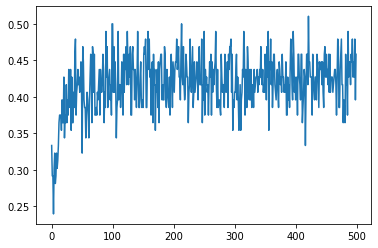

In [ ]:
from matplotlib import pyplot as plt
plt.plot(eval_acc)
print(np.mean(eval_acc))

2


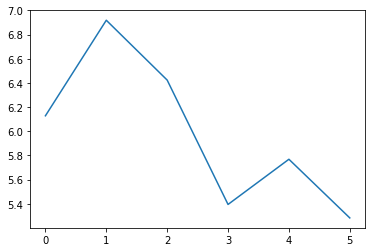

In [ ]:
y_true = []
y_pred = []
y_score = []
correct, total = 0, 0
running_loss = []
eval_loader = DataLoader(feature_dataset_val, 32)
for X, y in eval_loader:
    with torch.no_grad():
        output = model(X.cuda())
        preds = F.softmax(output, dim=1).cpu()
        preds = torch.argmax(preds, dim=1)
        #print(preds)
        y_ = torch.argmax(y, dim=1)
        #print(y_)
        correct = (preds == y_).sum().item()
        #y_true.append(y)
        #y_pred.append(preds)
        #y_score.append(F.softmax(output.data, dim=1).cpu())
        total += y.size(0)
        correct += (preds == y_).sum().item()
        running_loss.append(criterion(output, y.cuda()).item())
        #y_true = torch.cat(y_true)
        #y_pred = torch.cat(y_pred)
        #y_score = torch.cat(y_score)
        loss = np.mean(running_loss)
        acc = correct / total
        #auroc = metrics.roc_auc_score(y_true, y_score, multi_class="ovo")
        auroc = None
print(correct)
plt.plot(running_loss)

In [ ]:
feature_dir = './features/'
save_dir = './averaged_features/'
all_feature_files = list(glob.glob('./features/*.npy'))
all_feature_id = set()
for vid in all_feature_files:
  curr_id = vid.split('/')[-1].split('.')[0]
  all_feature_id.add(curr_id)

with open('./splits/nslt_100.json', 'r') as f:
  data = json.load(f)

lookup_table = {}
for vid_id in data.keys():
  if data[vid_id]['subset'] != 'train':
    continue
  if vid_id in all_feature_id:
    class_ = data[vid_id]['action'][0]
    if class_ not in lookup_table:
      lookup_table[class_] = []
    lookup_table[class_].append(vid_id)

print(len(lookup_table.keys()))

for class_ in lookup_table.keys():
  vids = lookup_table[class_]
  length = len(vids)
  combined = np.load(feature_dir + vids[0] + '.npy')
  for vid in vids:
    feature = np.load(feature_dir+vid+'.npy')
    combined += feature
  combined /= length
  save_file = save_dir + str(class_) + '.npy'
  np.save(save_file, combined)
  del combined





100


In [ ]:
a = np.load('./averaged_features/0.npy')
a.shape

(64, 2048)

In [ ]:
class custom_feature_extractor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.extractor = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, (3,5)), # 103, 304
        torch.nn.MaxPool2d((2,2)), # 51, 101 -> 25, 55 -> 12, 27
        torch.nn.Conv2d(32, 64, (3,5)),
        torch.nn.MaxPool2d((2,2)),
        torch.nn.Conv2d(64, 32, (3,5)),
        torch.nn.MaxPool2d((2,2)),
        torch.nn.Conv2d(32, 8, (3,5)),
        torch.nn.Flatten()
    )
    self.att = torch.nn.Linear(2448, 1)
    self.lstm = RNN_No_ATT(100, 2448, [512, 256])
    self.pred = torch.nn.Linear(2448, 100)

  def forward(self, x):
    b, l, c, h, w = x.shape
    features = []
    for i in range(b):
      feature = self.extractor(x[b])
      features.append(feature)
    features = torch.concat(features, dim=0)
    lstm = self.lstm(features)




In [ ]:
m = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, (3,5)), # 103, 304
        torch.nn.MaxPool2d((2,2)), # 51, 101 -> 25, 55 -> 12, 27
        torch.nn.Conv2d(32, 64, (3,5)),
        torch.nn.MaxPool2d((2,2)),
        torch.nn.Conv2d(64, 32, (3,5)),
        torch.nn.MaxPool2d((2,2)),
        torch.nn.Conv2d(32, 8, (3,5)),
        torch.nn.Flatten()
    )
inputs = torch.empty((50, 3, 103, 304))
outputs = m(inputs)
print(outputs.shape)

torch.Size([50, 2160])


In [ ]:
# dataset class used as input, produce (video_frames [64, 224, 224, 3], label) tuple
class VideoDataset(Dataset):
  def __init__(self, task, video_root_dir, json_file, num_desired_frames):
    super().__init__()
    self.task = task
    self.num_desired_frames = num_desired_frames
    self.num_class = 100
    self.info = self.extract_info_from_json(json_file, video_root_dir)

  def get_num_class(self, json_file):
    classes = set()    
    with open(json_file, 'r') as f:
      data = json.load(f)
    for vid_id in data.keys(): # get num clasees
      class_id = data[vid_id]['action'][0]
      classes.add(class_id)
    return len(classes)

  def __getitem__(self, idx):
    frames = torch.from_numpy(self.extract_frames(self.info[idx][0], self.info[idx][2]))
    label = self.info[idx][1]
    return frames, torch.from_numpy(label)

  def __len__(self):
    return len(self.info)

  # obtain information from nslt100.json/nslt300.json, which can be found in WLASL/code/I3D/preprocess
  def extract_info_from_json(self, split_file, video_root_dir):
    combined_info = []
    # some videos may be missing...
    all_videos = glob.glob(video_root_dir + '*.mp4')
    all_video_ids = [x.split('/')[-1].split('.')[0] for x in all_videos]
    with open(split_file, 'r') as f:
      data = json.load(f)

    for vid_id in data.keys():
      if (data[vid_id]['subset'] != self.task): # train, val, test?
        continue
      if vid_id not in all_video_ids:
        continue
      lab = data[vid_id]['action'][0]
      label = np.zeros((self.num_class, 1)) # compute label e.g., [0,0,0,0,0...1,0,0,0...]
      label[lab] = 1
      start = data[vid_id]['action'][1]
      vid_path = os.path.join(video_root_dir, vid_id + '.mp4')
      combined_info.append([vid_path, label, start]) # [/videos/00623.mp4, [0,0,1,0,...], 1]
    return combined_info

  # basically copied down the code 
  def extract_frames(self, video_filepath, start_frame):
    vidcap = cv2.VideoCapture(video_filepath)
    frames = []
    total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

    vidcap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    stepsize = int((total_frames - start_frame) // self.num_desired_frames)

    stepsize = int(max(stepsize, 1))

    count = 0
    for i in range(0, int(total_frames - start_frame), stepsize):
      if count == self.num_desired_frames:
        break
      ret, frame = vidcap.read()
      if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
      w, h, c = frame.shape
      
      if w < 226 or h < 226:
        d = 226. - min(w, h)
        sc = 1 + d / min(w, h)
        frame = cv2.resize(frame, dsize=(0, 0), fx=sc, fy=sc)
      if w > 256 or h > 256:
        frame = cv2.resize(frame, (math.ceil(w * (256 / w)), math.ceil(h * (256 / h))))
      #frame = (frame - np.mean(frame, axis=2)) / np.std(frame, axis=2)
      frame = (frame / 255.) * 2 - 1
      count += 1
      frames.append(frame)

    frames = np.asarray(frames, dtype=np.float32)
    if len(frames) < self.num_desired_frames:
      # add padding using 1st frame
      pad_img = frames[0]
      num_padding = self.num_desired_frames - len(frames)
      pad = np.tile(np.expand_dims(pad_img, axis=0), (num_padding, 1, 1, 1))
      frames = np.concatenate([frames, pad], axis=0)
      assert frames.shape[0] == self.num_desired_frames
    # center crop to 224 x 224
    # shape: t, w, h, c
    # may move this to another function
    t, h, w, c = frames.shape
    i = int(np.round((h - 224) / 2.))
    j = int(np.round((w - 224) / 2.))
    frames = frames[:, i:i+224, j:j+224, :]
    return frames





In [ ]:
# this is a pre-trained feature extractor, converting image to 2048-dimensional feature vector
class ResNet_extractor(torch.nn.Module):
    def __init__(self, layers=101):
        super().__init__()
        if layers == 18:
            self.resnet = torch_models.resnet18(pretrained=True)
        elif layers == 34:
            self.resnet = torch_models.resnet34(pretrained=True)
        elif layers == 50:
            self.resnet = torch_models.resnet50(pretrained=True)
        elif layers == 101:
            self.resnet = torch_models.resnet101(pretrained=True)
        else:
            raise(ValueError('Layers must be 18, 34, 50 or 101.'))

    def forward(self, x): # batch x 224 x 224 x 3
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        #print(x.shape)
        x = self.resnet.avgpool(x)
        #print(x.shape)
        x = torch.flatten(x, 1) # batch x 2048
        return x



In [ ]:
len(os.listdir('./features/'))

991

In [ ]:
# No need to run this
model = ResNet_extractor(34).cuda()
video_root_dir = './videos/'
with open('./splits/nslt_100.json', 'r') as f:
  data = json.load(f)
save_dir = './features/'
if os.path.isdir(save_dir):
  print("Feature file already exists, want to recreate?")
else:
  os.mkdir(save_dir)
feature_extraction(data, video_root_dir, save_dir, 50, model)
#dataset = VideoDataset('train', video_root_dir, split_file, 64, model)